In [1]:
import scipy.stats as sps
import numpy as np

В данной части мы генерируем синтетические данные, которые в дальнейшем будут использованы для проверки работы алгоритма.

In [2]:
# количество признаков
n = 30
# размер выборки
m = 100
def data_generator(n, m, cov=0.2):
    # cov - коэффициент, задающий ковариацию между значениями
    # исходная мартица ковариации (может не быть положительно определенной) 
    pred_C = (1 - cov) * np.eye(n) + cov * np.ones((n, n))
    # вектор средних значений
    mean = np.zeros((n, ))
    # новая матрица ковариации, близкая к исходной, но положительно определенная
    # и с более разнообразными собственными значениями
    C = np.cov(sps.multivariate_normal(mean, pred_C).rvs(size=m).T)
    # поделим строки и стобцы на корень из диагонали чтобы генерируемые Х имели
    # единичную дисперсию
    diag_sqrt = np.sqrt(np.diag(C))
    C = C / diag_sqrt
    C = C.T / diag_sqrt
    # генерируем выборку - она имеет нулевое матожидание и (почти) единичную 
    # дисперсию в каждом столбце
    X = sps.multivariate_normal(mean, C).rvs(size=m)
    # генерируем коэффициенты и делим их на соответствующее число, чтобы в итоге
    # дисперсия Z была равна 1
    a = sps.uniform(loc=0, scale=1).rvs(n)
    a /= (a.dot(a) * (1 - cov) + cov * (a.sum())**2)
    # генерируем предсказываемую переменную так, чтобы ее дисперсия была равна 1
    # для этого делим на соответствующий коэффициент 
    Z = X.dot(a) + sps.norm(loc=0, scale=0.1).rvs(size=m)

    return X, Z

Далее реализуем метод ForwardRegression и OMP


In [3]:
from sklearn.metrics import r2_score

def cov_score(y, y_pred, x_m):
    res = y - y_pred
    return np.abs(((res - res.mean())*(x_m - x_m.mean())).mean())

In [4]:
# def ForwardRegression(X, y, model, k, fitted=False):
#     if not fitted:
#         model.fit(X, y)
#     S = []
#     n = X.shape[1]
#     used = np.zeros((n, n))
#     scores = []
#     while len(S) < k:
#         max_score = 0
#         max_index = 0
#         for i in range(n):
#               if i not in S:
#                 used[i, i] = 1
#                 y_pred = model.predict(X.dot(used))
#                 used[i, i] = 0
#                 new_score = r2_score(y, y_pred)
#                 if new_score > max_score:
#                     max_index = i
#                     max_score = new_score
#         S.append(max_index)
#         used[max_index, max_index] = 1
#         scores.append(max_score)
#     return S, used, np.array(scores)

In [5]:
def ForwardRegression(X, y, model, k):
    S = []
    n = X.shape[1]
    scores = []
    while len(S) < k:
        max_score = 0
        max_index = 0
        for i in range(n):
              if i not in S:
                S.append(i)
                y_pred = model.fit(X.T[S].T, y).predict(X.T[S].T)
                S = S[: -1]
                new_score = r2_score(y, y_pred)
                if new_score > max_score:
                    max_index = i
                    max_score = new_score
        S.append(max_index)
        scores.append(max_score)
    return S, np.array(scores)

In [6]:
# def OMP(X, y, model, k, fitted=False):
#     if not fitted:
#         model.fit(X, y)
#     S = []
#     n = X.shape[1]
#     used = np.zeros((n, n))
#     scores = []
#     while len(S) < k:
#         max_score = 0
#         max_index = 0
#         for i in range(n):
#               if i not in S:
#                 y_pred = model.predict(X.dot(used))
#                 new_score = cov_score(y, y_pred, X.T[i])
#                 used[i, i] = 1
#                 y_pred = model.predict(X.dot(used))
#                 new_r2_score = r2_score(y, y_pred)
#                 used[i, i] = 0
#                 if new_score > max_score:
#                     max_index = i
#                     max_score = new_score
#                     max_r2_score = new_r2_score
#         S.append(max_index)
#         used[max_index, max_index] = 1
#         scores.append(max_r2_score)
#     return S, used, np.array(scores)

In [7]:
def OMP(X, y, model, k):
    S = []
    n = X.shape[1]
    scores = []
    while len(S) < k:
        max_score = 0
        max_index = 0
        for i in range(n):
              if i not in S:
                if len(S) != 0:
                    model.fit(X.T[S].T, y)
                    y_pred = model.predict(X.T[S].T)
                else:
                    y_pred = np.zeros(y.shape)
                new_score = cov_score(y, y_pred, X.T[i])
                S.append(i)
                model.fit(X.T[S].T, y)
                y_pred = model.predict(X.T[S].T)
                new_r2_score = r2_score(y, y_pred)
                S = S[: -1]
                if new_score > max_score:
                    max_index = i
                    max_score = new_score
                    max_r2_score = new_r2_score
        S.append(max_index)
        scores.append(max_r2_score)
    return S, np.array(scores)

In [8]:
# def ObliviousAlgorithm(X, y, model, k, fitted=False):
#     if not fitted:
#         model.fit(X, y)
#     x_norm = X - X.mean(axis=0)
#     y_norm = y - y.mean()
#     S = np.argsort(-np.abs((y * X.T).mean(axis=1)))[:k]
#     n = X.shape[1]
#     used = np.zeros((n, n))
#     scores = []
#     for s in S:
#         used[s, s] = 1
#         y_pred = model.predict(X.dot(used))
#         scores.append(r2_score(y, y_pred))
#     return S, used, np.array(scores)

In [9]:
def ObliviousAlgorithm(X, y, model, k, fitted=False):
    if not fitted:
        model.fit(X, y)
    x_norm = X - X.mean(axis=0)
    y_norm = y - y.mean()
    S = np.argsort(-np.abs((y * X.T).mean(axis=1)))[:k]
    n = X.shape[1]
    scores = []
    for i in range(len(S)):
        if i != 0:
            model.fit(X.T[S[:i]].T, y)
            y_pred = model.predict(X.T[S[:i]].T)
        else:
            y_pred = np.zeros(y.shape)
        scores.append(r2_score(y, y_pred))
    return S, np.array(scores)

In [10]:
from sklearn.linear_model import LinearRegression
from tqdm import trange


times = 30
n = 30
m = 100
k_max = n // 2
fw_result = np.zeros((k_max, ))
omp_result = np.zeros((k_max, ))
obl_result = np.zeros((k_max, ))
regression = LinearRegression()
for i in trange(times):
    x, z = data_generator(n, m)
    _, scores = ForwardRegression(x, z, regression, k_max)
    fw_result += scores
    _, scores = OMP(x, z, regression, k_max)
    omp_result += scores
    _, scores = ObliviousAlgorithm(x, z, regression, k_max)
    obl_result += scores
fw_result /= times
omp_result /= times
obl_result /= times

100%|██████████| 30/30 [00:18<00:00,  1.59it/s]


In [11]:
from matplotlib import pyplot as plt

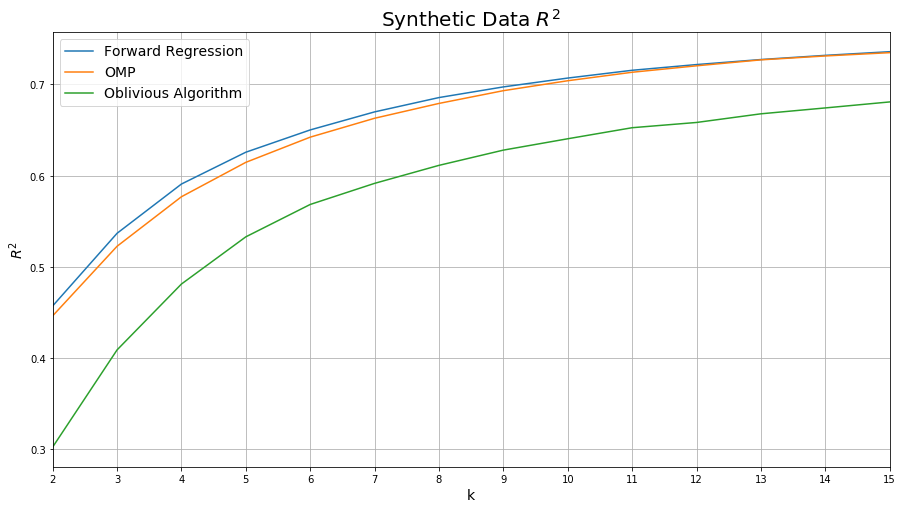

In [12]:
plt.figure(figsize=(15, 8))
K = range(2, k_max + 1)
plt.plot(K, fw_result[1:], label='Forward Regression')
plt.plot(K, omp_result[1:], label='OMP')
plt.plot(K, obl_result[1:], label='Oblivious Algorithm')
plt.xlim((min(K), max(K)))
plt.xlabel('k', fontsize=14)
plt.ylabel(r'$R^2$', fontsize=14)
plt.title(r"Synthetic Data $R^2$", fontsize=20)
plt.legend(fontsize=14)
plt.xticks(K)
plt.grid()
plt.savefig('sythetic_data.png')
plt.show()

In [13]:
from sklearn.datasets import load_boston
import pandas as pd
boston_dataset = load_boston()

In [14]:
X = np.array(pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names))
y = boston_dataset.target

In [15]:
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_norm = x_scaler.fit_transform(X)
y_norm = y_scaler.fit_transform(y[:, np.newaxis]).squeeze()

In [16]:
k_max = X.shape[1] * 2 / 3
fw_result = np.zeros((k_max, ))
omp_result = np.zeros((k_max, ))
obl_result = np.zeros((k_max, ))
regression = LinearRegression()
regression.fit(X_norm, y_norm)
_, fw_result = ForwardRegression(X_norm, y_norm, regression, k_max)
_, omp_result = OMP(X_norm, y_norm, regression, k_max)
_, obl_result = ObliviousAlgorithm(X_norm, y_norm, regression, k_max)

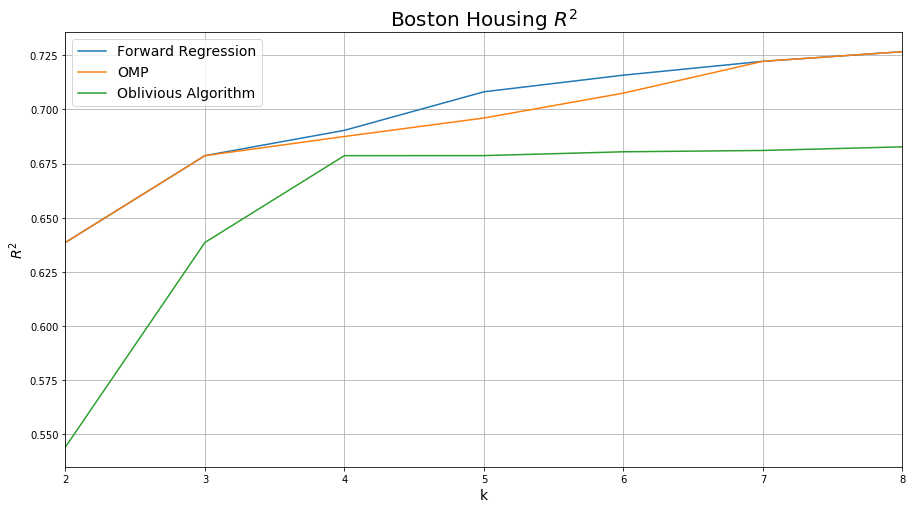

In [17]:
plt.figure(figsize=(15, 8))
K = range(2, k_max + 1)
plt.plot(K, fw_result[1:], label='Forward Regression')
plt.plot(K, omp_result[1:], label='OMP')
plt.plot(K, obl_result[1:], label='Oblivious Algorithm')
plt.xlim((min(K), max(K)))
plt.xlabel('k', fontsize=14)
plt.ylabel(r'$R^2$', fontsize=14)
plt.title(r"Boston Housing $R^2$", fontsize=20)
plt.legend(fontsize=14)
plt.xticks(K)
plt.grid()
plt.savefig('boston_housing.png')
plt.show()